In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, AUC
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [ ]:
metadata = pd.read_csv('../dataset/balanced_metadata.csv')
metadata

,image_name,target
0,Tr-glTr_0000.jpg,3
1,Tr-glTr_0001.jpg,3
2,Tr-glTr_0002.jpg,3
3,Tr-glTr_0003.jpg,3
4,Tr-glTr_0004.jpg,3
...,...,...
7995,rotated_180_Tr-pi_0079.jpg,1
7996,rotated_270_Tr-pi_0079.jpg,1
7997,rotated_90_Tr-pi_0080.jpg,1
7998,rotated_180_Tr-pi_0080.jpg,1


In [ ]:
image_folder = '../dataset/balanced_dataset/'
images = []
labels = []
for i, row in metadata.iterrows():
    img_path = os.path.join(image_folder, row['image_name'])
    img = load_img(img_path, target_size=(128, 128))
    images.append(img_to_array(img))
    labels.append(row['target'])

images = np.array(images) / 255.0  # Normalisation
labels = np.array(labels)
print(labels.shape)
print(labels[:10])

(8000,)
[3 3 3 3 3 3 3 3 3 3]


In [5]:
labels = to_categorical(labels, num_classes=4)
print(images.shape)  
print(labels.shape)

(8000, 128, 128, 3)
(8000, 4)


In [6]:
def build_cnn_model(input_shape=(128, 128, 3), num_classes=4, optimizer='adam',
                    dropout_rate=0.5, activation='relu', filters=32, kernel_size=(3, 3)):
    model = Sequential()

    # Première couche convolutionnelle
    model.add(Conv2D(filters, kernel_size, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Deuxième couche convolutionnelle
    model.add(Conv2D(filters * 2, kernel_size, activation=activation))
    model.add(MaxPooling2D((2, 2)))

    # Troisième couche convolutionnelle
    model.add(Conv2D(filters * 4, kernel_size, activation=activation))
    model.add(MaxPooling2D((2, 2)))

    # Aplatir les résultats des couches précédentes
    model.add(Flatten())

    # Couches entièrement connectées
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))  # Dropout pour éviter l'overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Classification multi-classe

    # Choisir l'optimiseur basé sur l'argument
    if optimizer == 'adam':
        optimizer_instance = Adam()
    elif optimizer == 'sgd':
        optimizer_instance = SGD()
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop()

    # Compiler le modèle avec les métriques supplémentaires
    model.compile(optimizer=optimizer_instance, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Recall(), AUC()])

    return model

In [13]:
# Grid search des paramètres
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],  # Optimiseur à tester
    'dropout_rate': [0.3, 0.5, 0.7],  # Taux de dropout
    'activation': ['relu', 'tanh', 'elu'],  # Fonction d'activation des couches
    'filters': [32],  # Nombre de filtres dans les couches convolutionnelles
    'kernel_size': [(3, 3)],  # Taille des noyaux de convolution
    'batch_size': [16, 32],  # Taille des mini-batchs
    'epochs': [5, 10]  # Nombre d'époques
}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.5, activation='relu', filters=32, kernel_size=(3, 3)):
    return build_cnn_model(input_shape=(128, 128, 3),
                           num_classes=4,
                           optimizer=optimizer,
                           dropout_rate=dropout_rate,
                           activation=activation,
                           filters=filters,
                           kernel_size=kernel_size)

In [ ]:
model = KerasClassifier(model=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_result = grid.fit(X_train, y_train)
print("\n[INFO] Recherche terminée.")
print(f"Meilleure combinaison de paramètres : {grid_result.best_params_}")
print(f"Meilleur score  : {grid_result.best_score_:.4f}")


[INFO] Test de la combinaison 1/108:
  Batch size: 16
  Epochs size: 5
  Optimizer: adam
  Dropout rate: 0.3
  Activation: relu
  Filters: 32
  Kernel size: (3, 3)
  Batch size: 16
  Epochs: 5
    Fold 1/3 : Entraînement et évaluation en cours...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


I0000 00:00:1733771826.191872    8983 service.cc:145] XLA service 0x781c300020e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733771826.191954    8983 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 24/267 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2582 - auc: 0.5509 - loss: 1.5614 - recall: 0.0195

I0000 00:00:1733771829.408641    8983 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


267/267 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5333 - auc: 0.8010 - loss: 1.0289 - recall: 0.3529
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8012 - auc: 0.9527 - loss: 0.5208 - recall: 0.7475
Epoch 3/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8706 - auc: 0.9800 - loss: 0.3292 - recall: 0.8612
Epoch 4/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9123 - auc: 0.9899 - loss: 0.2283 - recall: 0.9049
Epoch 5/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9400 - auc: 0.9950 - loss: 0.1571 - recall: 0.9371
    Fold 1/3 terminé : précision = 0.9213
    Fold 2/3 : Entraînement et évaluation en cours...
Epoch 1/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5661 - auc_1: 0.8163 - loss: 0.9914 - recall_1: 0.3719
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8111 - auc_1: 0.9572 - loss: 0.4907 - recall_1: 0.7746
Epoch 3/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8639 - auc_1: 0.9775 - loss

In [ ]:
best_model = grid_result.best_estimator_
best_params = grid_result.best_params_
print("Meilleure combinaison de paramètres : ", best_params)
print(f"Meilleur score  : {grid_result.best_score_:.4f}")

Meilleure combinaison de paramètres :  {'optimizer': 'adam', 'dropout_rate': 0.5, 'activation': 'relu', 'filters': 32, 'kernel_size': (3, 3), 'batch_size': 16, 'epochs': 10}
Meilleur score moyen :  0.9289


In [30]:
best_model = build_cnn_model(input_shape=(128, 128, 3), num_classes=4, 
                              optimizer=best_params['optimizer'],
                              dropout_rate=best_params['dropout_rate'], activation=best_params['activation'], 
                              filters=best_params['filters'], kernel_size=best_params['kernel_size'])

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

test_score = best_model.evaluate(X_test, y_test)
print(f"Score sur le jeu de test : {test_score[1]}") 

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5557 - auc_4: 0.8128 - loss: 1.0044 - recall_4: 0.3612
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7992 - auc_4: 0.9517 - loss: 0.5307 - recall_4: 0.7623
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8593 - auc_4: 0.9745 - loss: 0.3731 - recall_4: 0.8408
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8988 - auc_4: 0.9852 - loss: 0.2825 - recall_4: 0.8878
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9149 - auc_4: 0.9899 - loss: 0.2274 - recall_4: 0.9054
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9360 - auc_4: 0.9939 - loss: 0.1722 - recall_4: 0.9308
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9448 - auc_4: 0.9958 - loss: 0.1439 - recall_4: 0.9420
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9563 - auc_4: 0.9970 - loss: 0.1177 - recall_4: 0.9532
Epoch 9/10
400/400 ━━━━━━━━━━━━━

In [ ]:
best_model.save("../models/best_cnn_model.h5")
print("Modèle sauvegardé sous le nom 'best_cnn_model.h5'")

Modèle sauvegardé sous le nom 'best_cnn_model.h5'


In [32]:
results = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Loss sur le jeu de test : {results[0]:.4f}")
print(f"Accuracy : {results[1]:.4f}")
print(f"Recall : {results[2]:.4f}")
print(f"AUC : {results[3]:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9588 - auc_4: 0.9907 - loss: 0.1849 - recall_4: 0.9588
Loss sur le jeu de test : 0.1935
Accuracy : 0.9519
Recall : 0.9519
AUC : 0.9901


In [33]:
y_pred_prob = best_model.predict(X_test) 
y_pred = np.argmax(y_pred_prob, axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


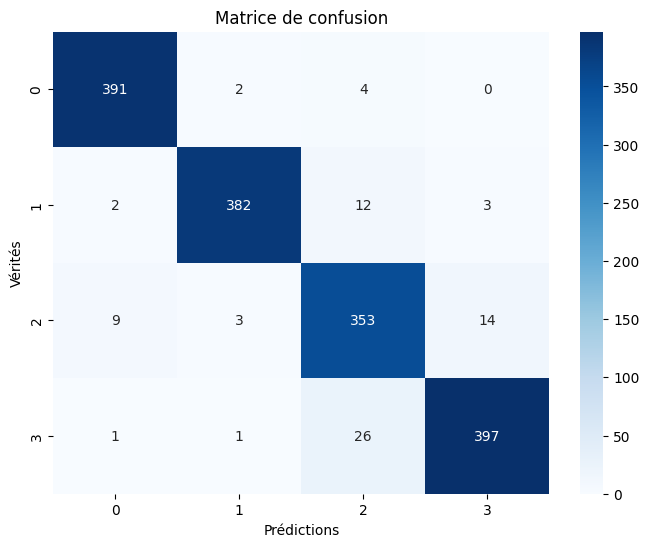

In [36]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.show()

In [37]:
print("\nRapport de classification :\n")
print(classification_report(np.argmax(y_test, axis=1), y_pred))


Rapport de classification :

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       397
           1       0.98      0.96      0.97       399
           2       0.89      0.93      0.91       379
           3       0.96      0.93      0.95       425

    accuracy                           0.95      1600
   macro avg       0.95      0.95      0.95      1600
weighted avg       0.95      0.95      0.95      1600



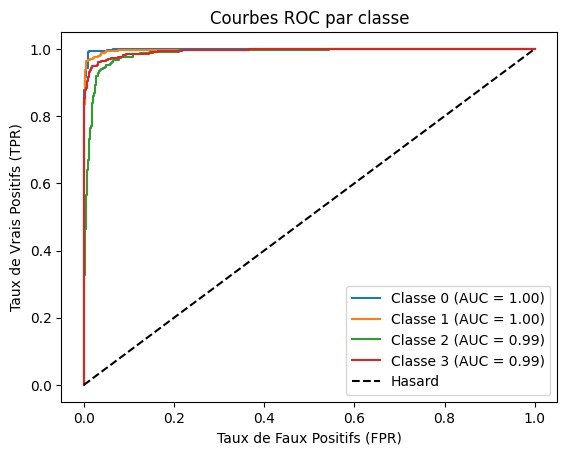

In [38]:
# AUC-ROC pour chaque classe
auc_scores = []
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {auc:.2f})')

# Courbe ROC globale
plt.plot([0, 1], [0, 1], 'k--', label='Hasard')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC par classe')
plt.legend(loc='best')
plt.show()

In [41]:
# AUC moyenne
auc_macro = np.mean(auc_scores)
print(f"AUC moyenne (macro) : {auc_macro:.4f}")

AUC moyenne (macro) : 0.9941
